# Investigating the DNN based electron ID

This study uses a flattened ntuple containing the DNN scores for individual electrons (along with other variables which I am ignoring for now).

The input file from which this flat ntuple is produced is a `DYJetsToLL_M-50` sample generated using `CMSSW_12_4_11_patch3`.

<br>**file:** `/store/mc/Run3Summer22MiniAODv3/DYJetsToLL_M-50_TuneCP5_13p6TeV-madgraphMLM-pythia8/MINIAODSIM/forPOG_124X_mcRun3_2022_realistic_v12-v4/70000/00162fe8-5a19-4c83-ac2a-a6d037507ecc.root`
<br>

The DNN-ID for the electrons is based on the following scores of a multiclassifier.
```
'dnn_signal_Isolated'
'dnn_signal_nonIsolated'
'dnn_bkg_nonIsolated'
'dnn_bkg_Tau'
'dnn_bkg_Photon'
```

The DNN-ID is given to a candidate if `dnn_signal_Isolated + dnn_signal_nonIsolated > 0.99`

#### The goal of this study is to check how much these scores and the DNN-ID overlaps with the analysis-level 'medium ID' electrons.


In [1]:
import os, sys
import uproot
infile = uproot.open("electron_ntuple.root")
print('The input file is read using uproot.')

The input file is read using uproot.


In [2]:
import pandas as pd
import numpy as np

tree = infile["ntuplizer/tree"]

branches = ['dnn_signal_Isolated', 'dnn_signal_nonIsolated', 'dnn_bkg_nonIsolated', 'dnn_bkg_Tau', 'dnn_bkg_Photon']

awkarray = tree.arrays(branches)

#Making a dataframe:
df = pd.DataFrame(awkarray.tolist())

#Adding two new columns:
#Column1 is a sum of all scores (which is supposed to be 1 by design)
df['sum'] = (
    df['dnn_signal_Isolated']+
    df['dnn_signal_nonIsolated']+
    df['dnn_bkg_nonIsolated']+
    df['dnn_bkg_Tau']+
    df['dnn_bkg_Photon']
)
#Column2 contains booleans of 'whether the candidate passes the DNN-ID or not'
df['dnn_id']= df['dnn_signal_Isolated']+df['dnn_signal_nonIsolated']> 0.99

#renaming columns for my convenience:
rename = {
    'dnn_signal_Isolated':'score1',
    'dnn_signal_nonIsolated':'score2',
    'dnn_bkg_nonIsolated':'score3',
    'dnn_bkg_Tau':'score4',
    'dnn_bkg_Photon':'score5'
}

df.rename(columns = rename, inplace = True)
df = df.sample(frac=1) #randomizing rows
df.reset_index(inplace=True, drop=True)

#Let's print some statments:
len_all = df.shape[0]
len_true = df[df['dnn_id']==True].shape[0]
len_false = df[df['dnn_id']==False].shape[0]

print('Dataframe is ready! This is how it looks like-\n')
print(df.head())
print(f'\nTotal number of candidates in this file = {len_all}')
print(f'Number of candidates passing the DNN ID = {len_true} ({len_true*100/len_all :.1f}%)')
print(f'Number of candidates failing the DNN ID = {len_false} ({len_false*100/len_all :.1f}%)')

Dataframe is ready! This is how it looks like-

     score1    score2    score3    score4    score5  sum  dnn_id
0  0.872005  0.000000  0.019328  0.000000  0.108668  1.0   False
1  0.015481  0.037103  0.490205  0.251374  0.205837  1.0   False
2  0.982359  0.001640  0.000068  0.003745  0.012188  1.0   False
3  0.735031  0.000000  0.025704  0.000000  0.239265  1.0   False
4  0.988994  0.004832  0.000011  0.000483  0.005679  1.0    True

Total number of candidates in this file = 23079
Number of candidates passing the DNN ID = 2567 (11.1%)
Number of candidates failing the DNN ID = 20512 (88.9%)


## Making some basic plots

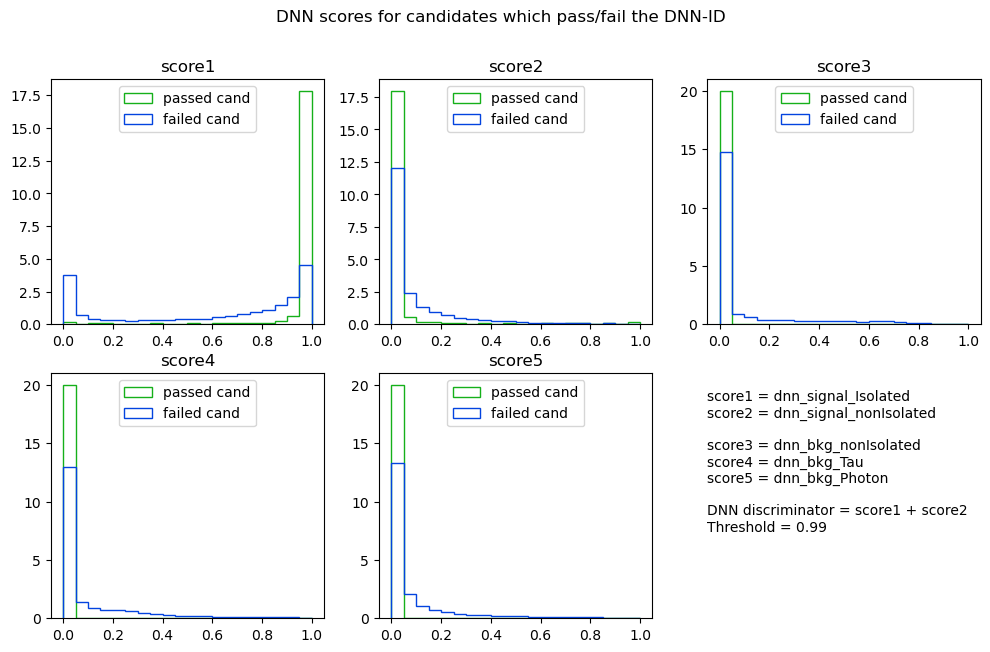

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(2,3,figsize=(12,7))
ax1 = ax1.flatten()

# Add the score details as left-aligned text
text = '''
score1 = dnn_signal_Isolated
score2 = dnn_signal_nonIsolated

score3 = dnn_bkg_nonIsolated
score4 = dnn_bkg_Tau
score5 = dnn_bkg_Photon

DNN discriminator = score1 + score2
Threshold = 0.99
'''

#fig1.subplots_adjust(hspace=0.5, wspace=0.1)
bins_=np.arange(0, 1.05, 0.05)
#fig1.delaxes(ax1[-1]) #Removing the last subplot
fig1.suptitle('DNN scores for candidates which pass/fail the DNN-ID') #Global title

var = ['score1', 'score2', 'score3', 'score4', 'score5']

for i in range(len(var)):
    ax1[i].hist(df[df['dnn_id']==True][var[i]], bins=bins_, histtype='step', color='xkcd:green',  label='passed cand', density=True)
    ax1[i].hist(df[df['dnn_id']==False][var[i]], bins=bins_, histtype='step', color='xkcd:blue',  label='failed cand', density=True)
    ax1[i].set_title(var[i])
    ax1[i].legend(loc='upper center')
    
ax1[-1].text(0, 1, text, transform=ax1[-1].transAxes, fontsize=10, ha='left', va='top')
ax1[-1].axis('off')

plt.show()

## ROC, discriminating score and working point of the DNN model